In [3]:
from PIL import Image
import datetime as dt

## *✭˚･ﾟ✧*･ﾟ 𝓬𝓪𝓷𝓪𝓭𝓲𝓪𝓷 𝓼𝓱𝓲𝓮𝓵𝓭 𝓭𝓲𝓼𝓬𝓱𝓪𝓻𝓰𝓮 𝓹𝓻𝓮𝓭𝓲𝓬𝓽𝓲𝓸𝓷 *✭˚･ﾟ✧*･ﾟ*

Taking notes as I go along...

---

I want to use a GCP VM for this project, just for practice. Set up one:

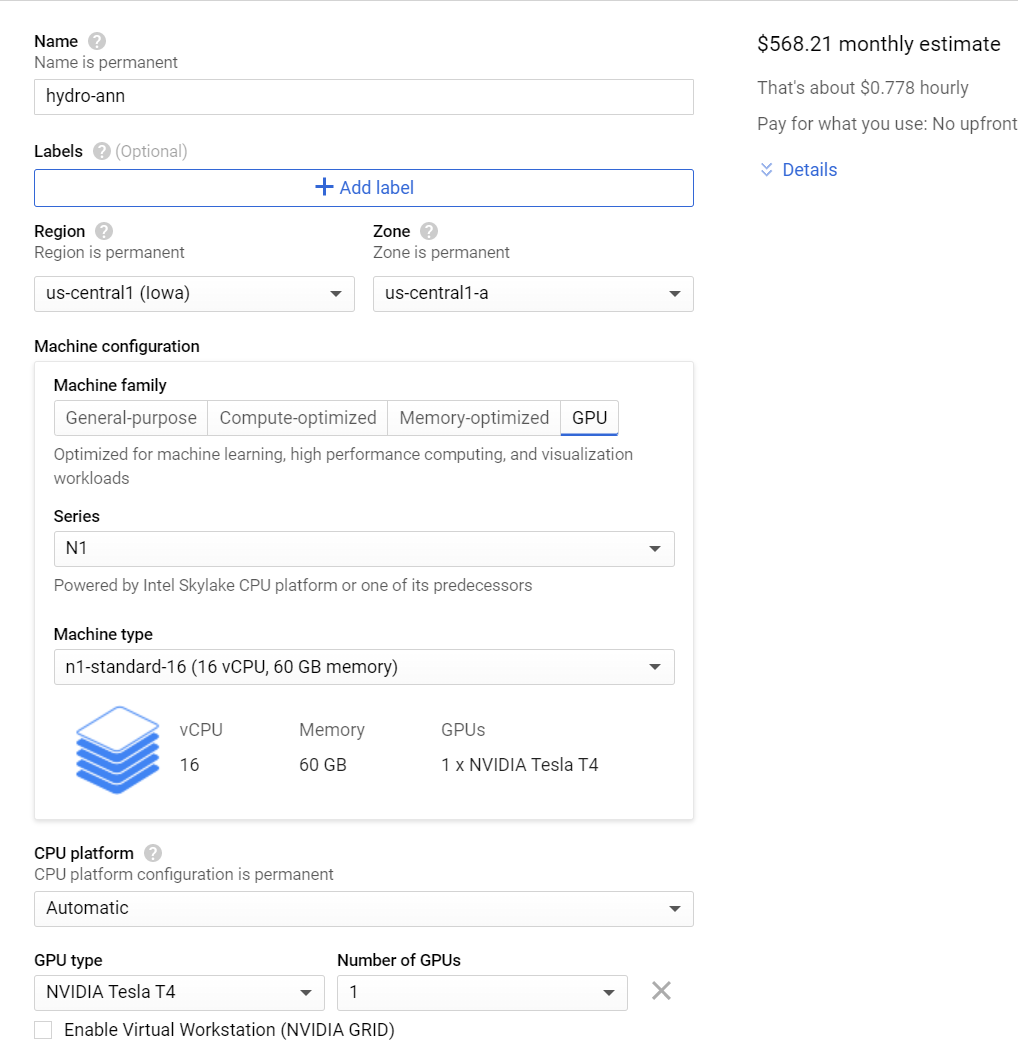

In [4]:
im = Image.open('misc_media/gcp_vm_0.png')
im

I assume I need a GPU for the ANN. Not sure exactly because I've never actually used one, but why not? However, there's the obvious price associaated with this... looks like it's about 0.70 per hour... Not the cheapest, but not the most expensive either (lol throwback to when I tried to use the ultra high memory VM and it cost 150 in a day. lesson learned, never again...)

I set it up with Ubuntu OS and 10 GB persistent disk

Then followed my tutorial for setting up an Ubuntu desktop... not really necessary (suppose everything could be done from command line) but maybe kind of convenient?

Just a reminder, to ssh into active VM instance via cmd type:

$ gcloud compute ssh hydro-ann --zone us-central1-a --ssh-flag "-L 5901:localhost:5901" 

And then you can access via VNC at 5901

Great okay now that that's done... what is this actual project going to be?

---

So, let's establish what data I'm using for this project:

 - ECCC discharge data
 (https://wateroffice.ec.gc.ca/mainmenu/real_time_data_index_e.html)
 <br>
 This is real-time and historic discharge data for all the ECCC stations in Canada.


- ECCC weather station data (https://climate.weather.gc.ca/historical_data/search_historic_data_e.html)
<br>
This is climate data for ECCC weather stations.

So obviously I cannot do this for all of the stations in Canada... probably makes sense to just choose a few stations to train and test on. And then can possibly expand to other stations to see if model is broadly applicable?

Let's say we have stations with nearby weather stations. We could do two different model trainings:

1. train using discharge stations and close by weather stations
2. train using discharge stations and ERA5 reanalysis

Then we could test to see how each performed. Does the ERA5 reanalysis do okay in comparison to the close by weather stations? Then, maybe this gives reason to believe resutls for stations without close-by weather stations. Don't know.

Regardless, I think I like the idea of choosing stations only with nearby weather stations for training. That way I can turn this variable on/off.

So, what stations?

- INDIN RIVER ABOVE CHALCO LAKE - (07SA004) and INDIN RIVER - (10757) - (data until 2004); about 0.25 km from each other; DATA EXISTS
- BAKER CREEK AT OUTLET OF LOWER MARTIN LAKE - (07SB013) and YELLOWKNIFE-HENDERSON - (45467) - (data until 2020); about 7 km from each other; DATA EXISTS
- HAY RIVER NEAR HAY RIVER - (07OB001) and HAY RIVER A - (1664) - (data until 2014); about 11 km from each other; DATA EXISTS
- HANBURY RIVER ABOVE HOARE LAKE - (06JB001) and HANBURY RIVER - (10897) - (data until 2020); about 1.6 km away from each other; DATA EXISTS
- SNARE RIVER BELOW GHOST RIVER - (07SA002) and INDIN RIVER - (10757) - (data until 2004); about 50 km away from each other; DATA EXISTS

я скучаю...

anyways

now I have 5 stations with nearby weather stations to use and varying time periods

---

download the data:

- 07SA004 ... done
- 07SB013 ... done
- 07OB001 ... done
- 06JB001 ... done
- 07SA002 ... done

- 10757 ... done 1997-2002
- 45467 ... done 2013-2018
- 1664 ... done 2009-2014
- 10897 ... done 2013-2018

** note: i might need to download more years for that weather station data if it doesn't overlap well with the discharge data

---

### Cleaning up the data and preliminary visualizations:

-

- Daily Discharge (m3/s) (PARAM = 1) and Daily Water Level (m) (PARAM = 2)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
indin = pd.read_csv(r'data/stream_flow/07SA004_daily.csv', sep='\\t')
baker = pd.read_csv(r'data/stream_flow/07SB013_daily.csv', sep= '\t')
hay = pd.read_csv(r'data/stream_flow/07OB001_daily.csv', sep= '\t')
hanbury = pd.read_csv(r'data/stream_flow/06JB001_daily.csv', sep= '\t')
snare = pd.read_csv(r'data/stream_flow/07SA002_daily.csv', sep= '\t')

In [ ]:
indin_flow = indin.loc[indin['PARAM'] == 1]
indin_lev = indin.loc[indin['PARAM'] == 2]

baker_flow = baker.loc[baker['PARAM'] == 1]
baker_lev = baker.loc[baker['PARAM'] == 2]

hay_flow = hay.loc[hay['PARAM'] == 1]
hay_lev = hay.loc[hay['PARAM'] == 2]

hanbury_flow = hanbury.loc[hanbury['PARAM'] == 1]
hanbury_lev = hanbury.loc[hanbury['PARAM'] == 2]

snare_flow = snare.loc[snare['PARAM'] == 1]
snare_lev = snare.loc[snare['PARAM'] == 2]

-

In [ ]:
var = snare_flow

In [ ]:
print(var.Date[0])
print(var.Date[len(var.Date)-1])

In [ ]:
print(len(var.Value))
print(len(var.Value) - np.count_nonzero(~np.isnan(var.Value)))
print(1 - np.count_nonzero(~np.isnan(var.Value))/len(var.Value))

-

In [ ]:
indin_flow.plot(x="Date", y="Value", figsize=(15,4))

In [ ]:
weather_0 = pd.read_csv(r'data/weather/10757/10757_1997_daily.csv', sep=',')
weather_1 = pd.read_csv(r'data/weather/10757/10757_1998_daily.csv', sep=',')
weather_2 = pd.read_csv(r'data/weather/10757/10757_1999_daily.csv', sep=',')
weather_3 = pd.read_csv(r'data/weather/10757/10757_2000_daily.csv', sep=',')
weather_4 = pd.read_csv(r'data/weather/10757/10757_2001_daily.csv', sep=',')
weather_5 = pd.read_csv(r'data/weather/10757/10757_2002_daily.csv', sep=',')

al = [weather_0, weather_1, weather_2, weather_3, weather_4, weather_5]

In [ ]:
indin_weather = pd.concat(al)

In [ ]:
dt.datetime.strptime((indin_flow['Date'][0]), '%m-%d-%Y')

In [ ]:
indin_flow[(indin_flow['Date'] > '01-01-1997') & (indin_flow['Date'] < '31-12-2002')]

In [ ]:
indin_flow.plot(x="Date", y="Value", figsize=(15,4))
plt.title("Indin River above Chalco Lake, Discharge")
plt.ylabel('Discharge [m/s^3]')
plt.xlabel("Date")
plt.savefig('indinriver.png')